<a href="https://colab.research.google.com/github/chongzicbo/Dive-into-Deep-Learning-tf.keras/blob/master/7.7.%20AdaDelta%E7%AE%97%E6%B3%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##7.7. AdaDelta算法
除了RMSProp算法以外，另一个常用优化算法AdaDelta算法也针对AdaGrad算法在迭代后期可能较难找到有用解的问题做了改进 [1]。有意思的是，AdaDelta算法没有学习率这一超参数。

###7.7.1. 算法
AdaDelta算法也像RMSProp算法一样，使用了小批量随机梯度$ g_t$ 按元素平方的指数加权移动平均变量 $s_t$ 。在时间步0，它的所有元素被初始化为0。给定超参数$0 \leq \rho < 1$(对应RMSProp算法中的$\gamma$ )，在时间步 $t>0$ ，同RMSProp算法一样计算
$$
\boldsymbol{s}_t \leftarrow \rho \boldsymbol{s}_{t-1} + (1 - \rho) \boldsymbol{g}_t \odot \boldsymbol{g}_t.
$$
与RMSProp算法不同的是，AdaDelta算法还维护一个额外的状态变量$\Delta\boldsymbol{x}_t$，其元素同样在时间步0时被初始化为0。我们使用 $\Delta\boldsymbol{x}_{t-1}$来计算自变量的变化量：
$$
\boldsymbol{g}_t' \leftarrow \sqrt{\frac{\Delta\boldsymbol{x}_{t-1} + \epsilon}{\boldsymbol{s}_t + \epsilon}}   \odot \boldsymbol{g}_t,
$$
其中 $\epsilon$ 是为了维持数值稳定性而添加的常数，如 $10^{-5}$ 。接着更新自变量：
$$
\boldsymbol{x}_t \leftarrow \boldsymbol{x}_{t-1} - \boldsymbol{g}'_t.
$$
最后，我们使用$\Delta\boldsymbol{x}_t$来记录自变量变化量$\boldsymbol{g}'_t$按元素平方的指数加权移动平均：
$$
\Delta\boldsymbol{x}_t \leftarrow \rho \Delta\boldsymbol{x}_{t-1} + (1 - \rho) \boldsymbol{g}'_t \odot \boldsymbol{g}'_t.
$$

可以看到，如不考虑 $\epsilon$的影响，AdaDelta算法与RMSProp算法的不同之处在于使用$\sqrt{\Delta\boldsymbol{x}_{t-1}}$来替代超参数$\eta$ 。

###7.7.2. 从零开始实现
AdaDelta算法需要对每个自变量维护两个状态变量，即 $\boldsymbol{s}_t$和$\Delta\boldsymbol{x}_t$。我们按AdaDelta算法中的公式实现该算法。

In [0]:
%matplotlib inline
import math
import tensorflow as tf
import numpy as np
from IPython import display
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import losses
from tensorflow.data import Dataset
import time

In [0]:
tf.enable_eager_execution()

In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

def get_data_ch7():
  data=np.genfromtxt('/content/drive/My Drive/data/d2l-zh-tensoflow/airfoil_self_noise.dat',delimiter='\t')
  data=(data-data.mean(axis=0))/data.std(axis=0)
  return tf.constant(data[:1500,:-1]),tf.constant(data[:1500,-1])

features,labels=get_data_ch7()  

In [0]:
def init_adadelta_states():
  s_w,s_b=tf.Variable(tf.zeros((features.shape[1],1),dtype=tf.double)),tf.Variable(tf.zeros(1,dtype=tf.double))
  delta_w,delta_b=tf.Variable(tf.zeros(shape=(features.shape[1],1),dtype=tf.double)),tf.Variable(tf.zeros(1,dtype=tf.double))
  return ((s_w,delta_w),(s_b,delta_b))

In [0]:
def adadelta(params,states,hyperparams,loss,t):
  rho,eps=hyperparams['rho'],1e-5
  for p,(s,delta) in zip(params,states):
    dl_dp=t.gradient(loss,p)
    s.assign(rho*s+(1-rho)*tf.square(dl_dp))
    g=(tf.sqrt((delta+eps))/tf.sqrt((s+eps)))*dl_dp
    p.assign_sub(g)
    delta.assign(rho*delta+(1-rho)*g*g)

In [0]:
def train_ch7(trainer_fn,states,hyperparams,features,labels,batch_size=10,num_epochs=2):
  net,loss=linreg,squared_loss
  w=tf.Variable(tf.random.normal(stddev=0.01,shape=(features.shape[1],1),dtype=tf.double))
  b=tf.Variable(tf.zeros(1,dtype=tf.double))

  def eval_loss():
    return tf.reduce_mean(loss(net(features,w,b),labels)).numpy()

  ls=[eval_loss()]

  data_iter=Dataset.from_tensor_slices((features,labels)).shuffle(buffer_size=1000).batch(batch_size)

  for _ in range(num_epochs):
    start=time.time()
    for batch_i,(X,y) in enumerate(data_iter):
      with tf.GradientTape(persistent=True) as t:
        t.watch([w,b])
        l=tf.reduce_mean(loss(net(X,w,b),y)) #使用平均损失

      trainer_fn([w,b],states,hyperparams,l,t) #迭代模型参数

      if(batch_i+1)*batch_size %100==0:
        ls.append(eval_loss()) #每100个样本记录下当前训练误差
  # 打印结果和作图
  print('loss: %f, %f sec per epoch' % (ls[-1], time.time() - start))
  set_figsize()
  plt.plot(np.linspace(0, num_epochs, len(ls)), ls)
  plt.xlabel('epoch')
  plt.ylabel('loss')  


def use_svg_display():
  #用矢量图显示
  display.set_matplotlib_formats('svg')
def set_figsize(figsize=(3.5,2.5)):
  use_svg_display()
  #设置图的尺寸
  plt.rcParams['figure.figsize']=figsize
  
  
def linreg(X,w,b):
  return tf.matmul(X,w)+b 
  
def squared_loss(y_hat,y):
  return (y_hat-tf.reshape(y,shape=y_hat.shape))**2/2    

使用超参数 $\rho=0.9$来训练模型。

loss: 0.242666, 0.598813 sec per epoch


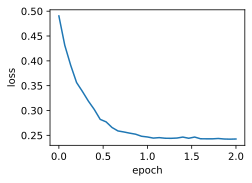

In [0]:
train_ch7(adadelta,init_adadelta_states(),{'rho':0.9},features,labels)

###7.7.3. 简洁实现

In [0]:
def train_keras_ch7(trainer_name,features,labels,batch_size=10,num_epochs=2):
  net=keras.Sequential(keras.layers.Dense(1))
  loss=losses.MeanSquaredError()
  data_iter=Dataset.from_tensor_slices((features,labels)).shuffle(buffer_size=1000).batch(batch_size)
  net.compile(optimizer=trainer_name,loss=loss,metrics=['mse'])
  history=net.fit_generator(data_iter,epochs=num_epochs)
  loss_ls=history.history['loss']
  set_figsize()
  plt.plot(np.linspace(0,num_epochs,len(loss_ls)),loss_ls)
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.show()
  return history

Epoch 1/20
150/150 [==============================] - 1s 9ms/step - loss: 0.5774 - mean_squared_error: 0.5993
Epoch 2/20
150/150 [==============================] - 1s 7ms/step - loss: 0.5132 - mean_squared_error: 0.4806
Epoch 3/20
150/150 [==============================] - 1s 8ms/step - loss: 0.5048 - mean_squared_error: 0.4712
Epoch 4/20
150/150 [==============================] - 1s 8ms/step - loss: 0.4995 - mean_squared_error: 0.4660
Epoch 5/20
150/150 [==============================] - 1s 7ms/step - loss: 0.4957 - mean_squared_error: 0.4626
Epoch 6/20
150/150 [==============================] - 1s 7ms/step - loss: 0.4929 - mean_squared_error: 0.4601
Epoch 7/20
150/150 [==============================] - 1s 7ms/step - loss: 0.4909 - mean_squared_error: 0.4584
Epoch 8/20
150/150 [==============================] - 1s 9ms/step - loss: 0.4895 - mean_squared_error: 0.4573
Epoch 9/20
150/150 [==============================] - 1s 9ms/step - loss: 0.4884 - mean_squared_error: 0.4565
Epoch 10/2

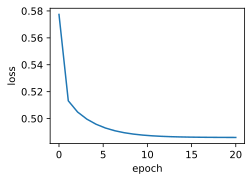

In [0]:
train_keras_ch7(keras.optimizers.Adadelta(learning_rate=0.1,rho=0.99,epsilon=1e-5),features,labels,batch_size=10,num_epochs=20)

###7.7.4. 小结
* AdaDelta算法没有学习率超参数，它通过使用有关自变量更新量平方的指数加权移动平均的项来替代RMSProp算法中的学习率。